# Generating Molecules with MolGAN

In this tutorial, we will train a MolGAN network on the tox21 dataset which is a dataset of 12,060 training samples and 647 test samples of chemical compounds. The MolGAN network was first introduced in "MolGAN: An implicit generative model for small molecular graphs" by Cao and Kipf. It uses a GAN directly on graph data and a reinforcement learning objective to induce the network to generate molecules with certain chemical properties.

The architecture consits of 3 main sections: a generator, a discriminator, and a reward network.

The generator takes a sample (z) from a standard normal distribution to generate an a graph using a MLP (this limits the network to a fixed maximum size) to generate the graph at once. Sepcifically a dense adjacency tensor A (bond types) and an annotation matrix X (atom types) are produced. Since these are probabilities, a discrete, sparse x and a are generated through categorical sampling.

The discriminator and reward network have the same architectures and recieve graphs as inputs. A Relational-GCN and MLPs are used to produce the singular output.

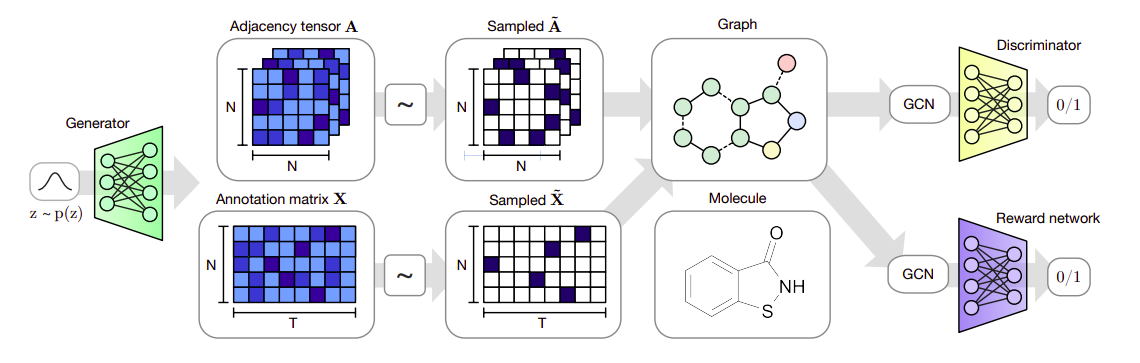

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Generating_molecules_with_MolGAN.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands.

In [43]:
!pip install uv
!uv pip install --pre deepchem
import deepchem
deepchem.__version__

Using Python 3.11.12 environment at: /usr
Audited 1 package in 81ms


'2.8.1.dev'

Import the packages you'll need.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import OrderedDict

import deepchem as dc
import deepchem.models
import torch
from deepchem.models.torch_models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
from torch.nn.functional import one_hot
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

Download, load, and extract the SMILES strings from the tox21 dataset. The original paper used the QM9 dataset, however we use the tox21 dataset here to save time.

In [45]:
# Download from MolNet
# Try tox21 or LIPO dataset
tasks, datasets, transformers = dc.molnet.load_tox21()
df = pd.DataFrame(data={'smiles': datasets[0].ids})

Specify the maximum number of atoms to enocde for the featurizer and the MolGAN network. The higher the number of atoms, the more data you'll have in the dataset. However, this also increases the model complexity as the input dimensions become higher.

In [46]:
num_atoms = 12

In [47]:
df

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6253,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6254,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6255,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C
6256,CC(C)CCC[C@@H](C)[C@H]1CC(=O)C2=C3CC[C@H]4C[C@...


Uncomment the first line if you want to subsample from the full dataset.

In [48]:
#data = df[['smiles']].sample(4000, random_state=42)
data = df

Initialize the featurizer with the maxmimum number of atoms per molecule. atom_labels is a parameter to pass the atomic number of atoms you want to be able to parse. Similar to the num_atoms parameter above, more atom_labels means more data, though the model gets more complex/unstable.

In [49]:
# create featurizer
feat = dc.feat.MolGanFeaturizer(max_atom_count=num_atoms, atom_labels=[0, 5, 6, 7, 8, 9, 11, 12, 13, 14]) #15, 16, 17, 19, 20, 24, 29, 35, 53, 80])

Extract the smiles from the dataframe as a list of strings

In [50]:
smiles = data['smiles'].values

Filter out the molecules with too many atoms to reduce the number of unnecessary error messages in later steps.

In [51]:
filtered_smiles = [x for x in smiles if Chem.MolFromSmiles(x).GetNumAtoms() < num_atoms]

[08:26:20] WARNING: not removing hydrogen atom without neighbors


The next cell featurizes the filtered molecules, however, since we have limited the atomic numbers to `[5, 6, 7, 8, 9, 11, 12, 13, 14]` which is B, C, N, O, F, Na, Mg, Al and Si, the featurizer fails to featurize several molecules in the dataset. Feel free to experiment with more atomic numbers!

In [52]:
# featurize molecules
features = feat.featurize(filtered_smiles)

[08:26:22] WARNING: not removing hydrogen atom without neighbors


Remove more invalid molecules.

In [53]:
indices = [ i for i, data in enumerate(features) if type(data) is GraphMatrix ]
print(indices)
features = [features[i] for i in indices]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 34, 35, 36, 37, 38, 43, 46, 47, 48, 50, 51, 52, 53, 56, 58, 59, 60, 62, 63, 64, 65, 69, 70, 72, 73, 74, 76, 77, 78, 79, 80, 83, 84, 85, 86, 88, 89, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 109, 110, 111, 112, 113, 114, 115, 119, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 137, 138, 139, 140, 143, 144, 145, 149, 150, 157, 159, 164, 165, 169, 170, 171, 172, 173, 174, 176, 177, 179, 181, 182, 184, 186, 188, 189, 191, 192, 196, 197, 198, 199, 202, 205, 206, 207, 208, 209, 213, 215, 216, 219, 220, 221, 222, 225, 226, 227, 229, 231, 232, 233, 234, 235, 236, 237, 239, 240, 244, 247, 248, 249, 252, 254, 255, 256, 257, 258, 261, 262, 264, 265, 266, 268, 269, 270, 273, 274, 275, 277, 278, 280, 283, 285, 286, 287, 288, 289, 292, 296, 297, 298, 299, 300, 301, 302, 303, 304, 306, 307, 308, 309, 312, 313, 314, 315, 317, 318, 319, 322, 323, 324, 325, 326, 327, 328, 329, 33

Instantiate the MolGAN model and set the learning rate and maximum number of atoms as the size of the vertices. Then, we create the dataset in the format of the input to MolGAN.

In [54]:
# create model
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), vertices=num_atoms)
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])

Define the iterbatches function because the gan_fit function requires an iterable for the batches.

In [55]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            flattened_adjacency = torch.from_numpy(batch[0]).view(-1).to(dtype=torch.int64) # flatten the input because torch.nn.functional.one_hot only works with 1D inputs
            invalid_mask = (flattened_adjacency < 0) | (flattened_adjacency >= gan.edges) # edge type cannot be negative or >= gan.edges, these entries are invalid
            clamped_adjacency = torch.clamp(flattened_adjacency, 0, gan.edges-1) # clamp the input so it can be fed to the one_hot function
            adjacency_tensor = one_hot(clamped_adjacency, num_classes=gan.edges) # actual one_hot
            adjacency_tensor[invalid_mask] = torch.zeros(gan.edges, dtype=torch.long) # make the invalid entries, a vector of zeros
            adjacency_tensor = adjacency_tensor.view(*batch[0].shape, -1) # reshape to original shape and change dtype for stability.

            flattened_node = torch.from_numpy(batch[1]).view(-1).to(dtype=torch.int64)
            invalid_mask = (flattened_node < 0) | (flattened_node >= gan.nodes)
            clamped_node = torch.clamp(flattened_node, 0, gan.nodes-1)
            node_tensor = one_hot(clamped_node, num_classes=gan.nodes)
            node_tensor[invalid_mask] = torch.zeros(gan.nodes, dtype=torch.long)
            node_tensor = node_tensor.view(*batch[1].shape, -1)

            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

Train the model with the fit_gan function and generate molecules with the predict_gan_generator function.

In [56]:
gan.fit_gan(iterbatches(25), generator_steps=0.2, checkpoint_interval=5000)
generated_data = gan.predict_gan_generator(1000)

Ending global_step 349: generator average loss -2.7119, discriminator average loss -9.67134
TIMING: model fitting took 13.124 s
Generating 1000 samples


Convert the generated graphs to RDKit molecules.

In [57]:
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))

1000 molecules generated


Remove invalid molecules from list.

In [58]:
nmols = list(filter(lambda x: x is not None, nmols))

Print out the number of valid molecules, but training can be unstable so some the number can vary significantly.

In [59]:
# currently training is unstable so 0 is a common outcome
print ("{} valid molecules".format(len(nmols)))

620 valid molecules


In [60]:
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import Draw

nmols_smiles = [Chem.MolToSmiles(m) for m in nmols]
nmols_smiles_unique = list(OrderedDict.fromkeys(nmols_smiles))
nmols_viz = [Chem.MolFromSmiles(x) for x in nmols_smiles_unique]
print ("{} unique valid molecules".format(len(nmols_viz)))

21 unique valid molecules


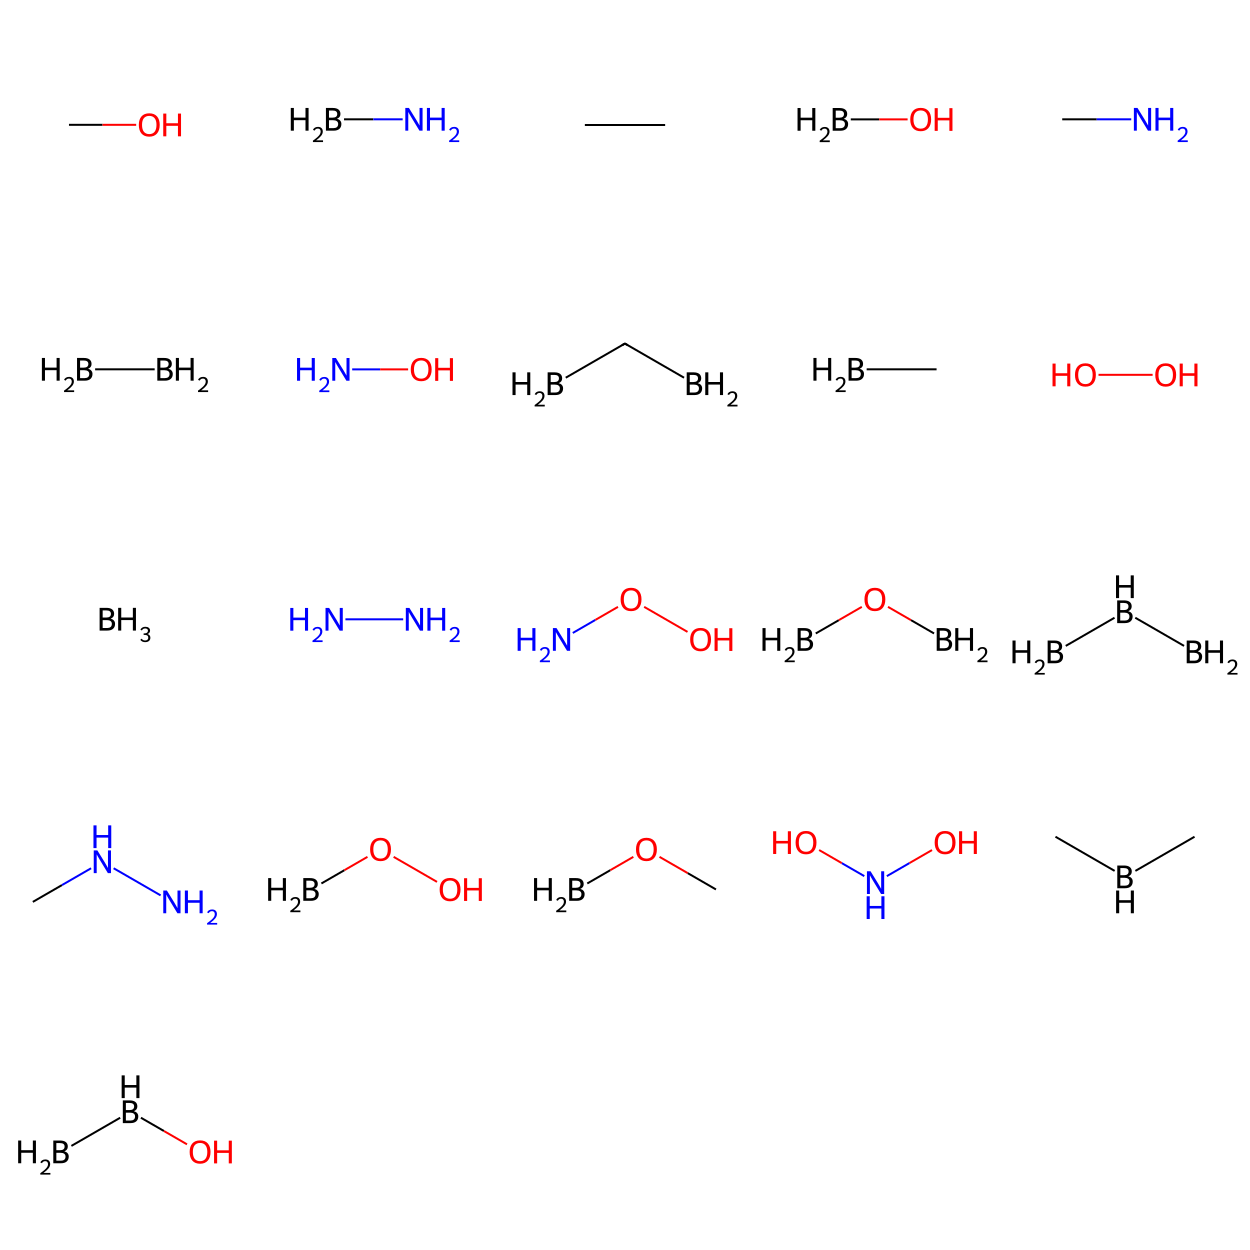

In [61]:
from rdkit.Chem import Draw
from IPython.display import display

if nmols_viz:
    # Only attempt to draw if there are valid molecules
    img = Draw.MolsToGridImage(nmols_viz[0:100], molsPerRow=5, subImgSize=(250, 250), maxMols=100, legends=None, returnPNG=False)
    display(img)
else:
    print("No unique valid molecules to display.")

Remove duplicate generated molecules.

Print out up to 100 unique valid molecules.

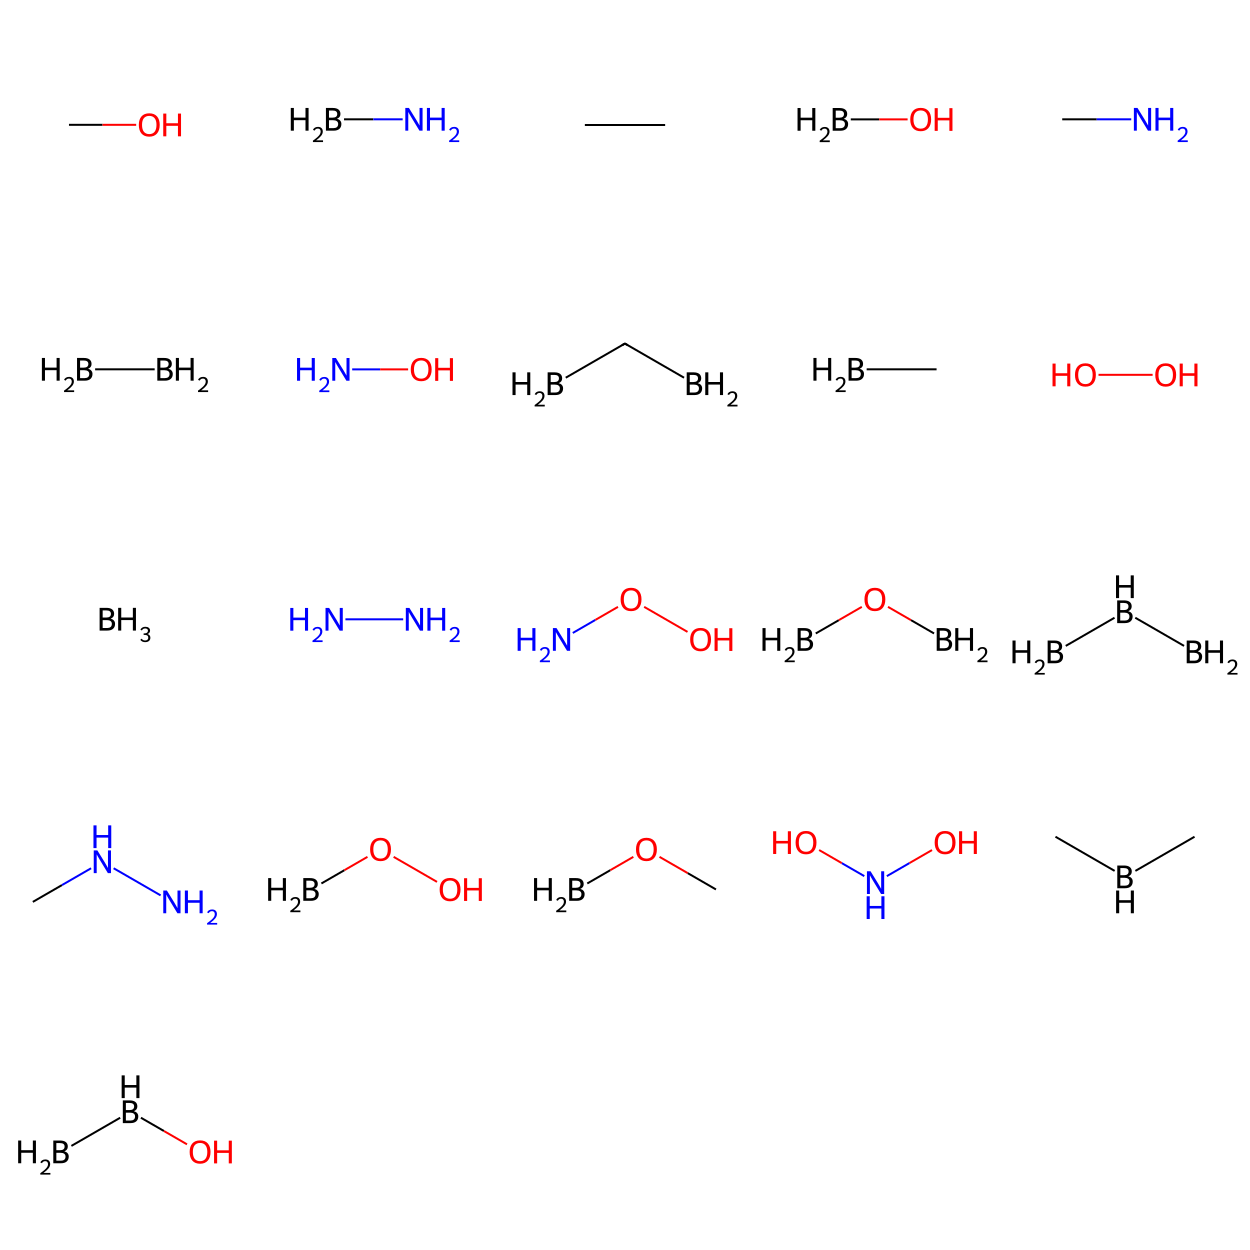

In [62]:
img

This is an example of what the molecules should look like.

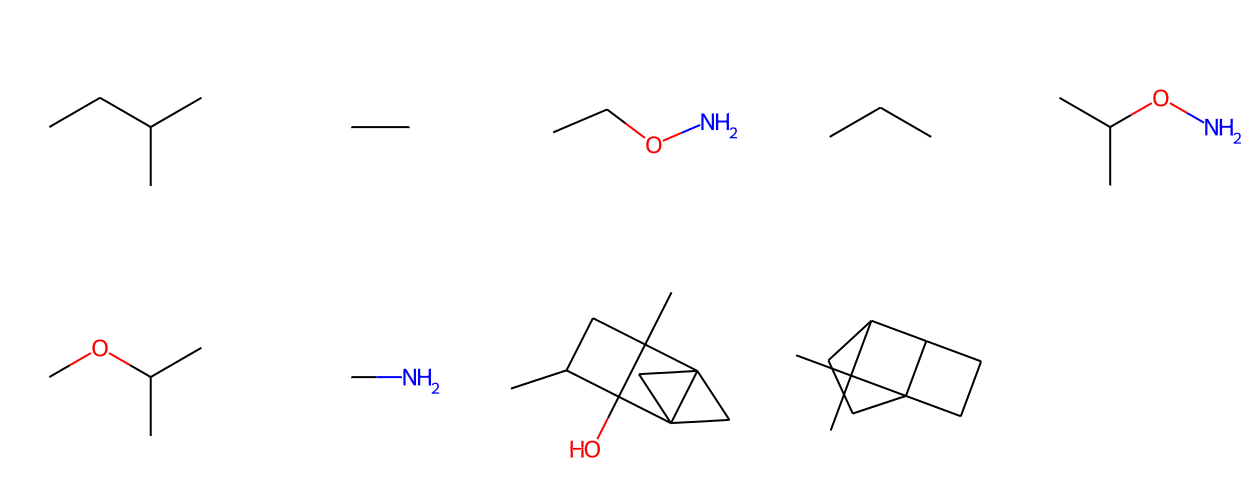